
Processing /data/shared/CSIT_Placement_2025_3D_Reef/CBHE_BA2D_P1/images/frame_00002.JPG with point prompts [(619, 988), (822, 1009), (761, 845), (737, 976), (813, 626), (901, 672), (657, 835), (770, 776), (928, 847), (765, 632), (924, 843), (914, 716)]
Top mask score: 0.677


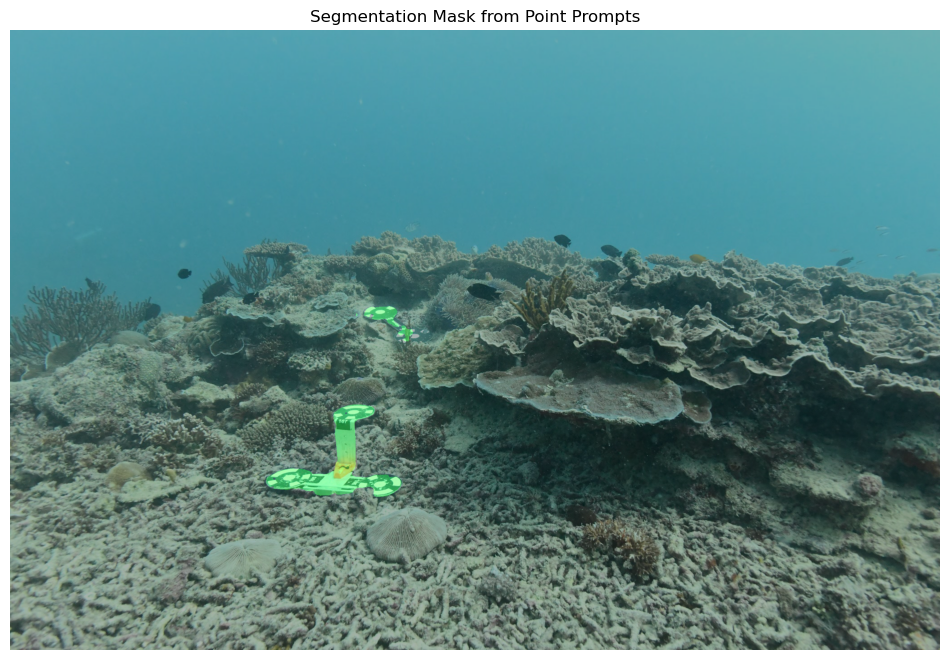


Processing /data/shared/CSIT_Placement_2025_3D_Reef/CBHE_BA2D_P1/images/frame_00007.JPG with point prompts [(1024, 688), (1235, 749), (1180, 551), (1162, 641), (1222, 116), (1192, 392), (1152, 139), (1332, 282), (1308, 565), (1107, 115), (1100, 121)]
Top mask score: 0.699


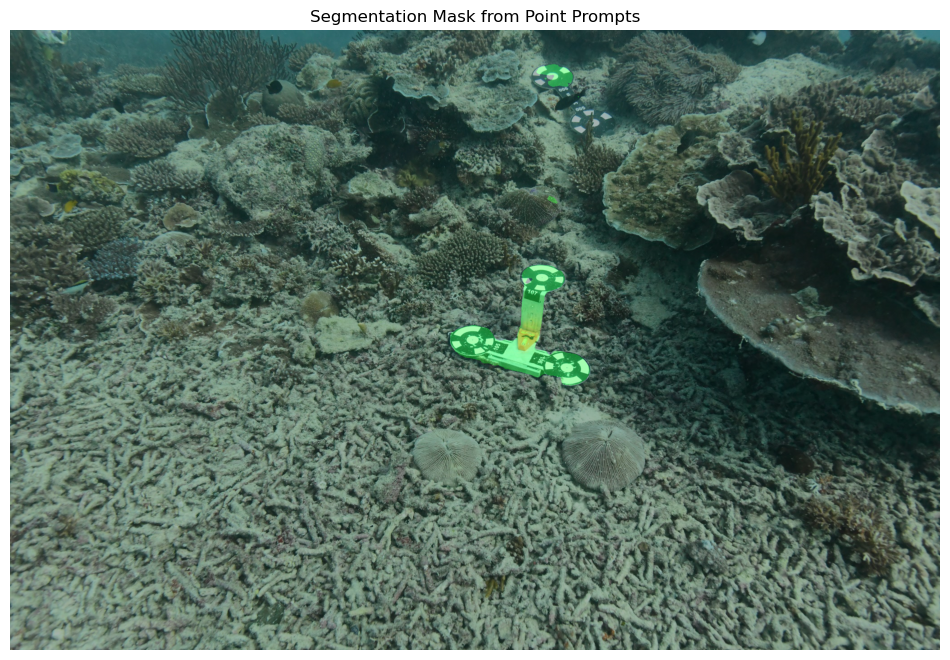


Processing /data/shared/CSIT_Placement_2025_3D_Reef/CBHE_BA2D_P1/images/frame_00025.JPG with point prompts [(1073, 366), (1281, 751)]
Top mask score: 0.912


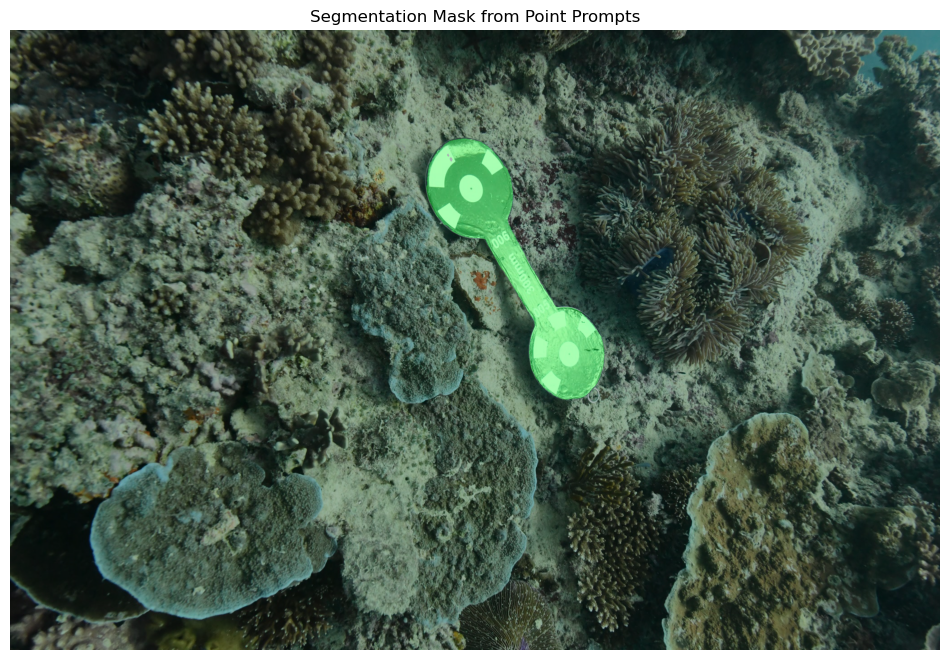

Point-prompt segmentation complete.


In [3]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# === Load and wrap the SAM model ===
class ModelLoader:
    def __init__(self, model_type: str, checkpoint_path: str, device: torch.device):
        self.model_type = model_type
        self.checkpoint_path = checkpoint_path
        self.device = device
        self.model = self.load_model()

    def load_model(self):
        sam = sam_model_registry[self.model_type](checkpoint=self.checkpoint_path)
        sam.to(device=self.device)
        return sam

# === Load image and convert to RGB ===
class ImageProcessor:
    def __init__(self, image_path: str):
        self.image_path = image_path
        self.image_bgr = cv2.imread(image_path)
        self.image_rgb = cv2.cvtColor(self.image_bgr, cv2.COLOR_BGR2RGB)

# === Generate masks from point prompts ===
class PointMaskGenerator:
    def __init__(self, sam_model):
        self.predictor = SamPredictor(sam_model)

    def generate_mask_from_points(self, image_rgb: np.ndarray, points: list, labels: list):
        self.predictor.set_image(image_rgb)
        input_point = np.array(points)
        input_label = np.array(labels, dtype=int)
        masks, scores, logits = self.predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True
        )
        return masks, scores

# === Annotate mask by overlaying it on the image ===
class AnnotationDisplay:
    def show_annotations(self, masks: np.ndarray, image_bgr: np.ndarray):
        mask = masks[0].astype(np.uint8)  # Top mask
        colored_mask = np.zeros_like(image_bgr)
        colored_mask[mask == 1] = [0, 255, 0]  # Green mask

        overlay = cv2.addWeighted(image_bgr, 0.7, colored_mask, 0.3, 0)
        image_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 12))
        plt.imshow(image_rgb)
        plt.title("Segmentation Mask from Point Prompts")
        plt.axis("off")
        plt.show()

# === High-level runner ===
class SegmentationPipelineWithPoints:
    def __init__(self, model_type, checkpoint_path, device, image_paths, point_prompts):
        self.model_loader = ModelLoader(model_type, checkpoint_path, device)
        self.mask_generator = PointMaskGenerator(self.model_loader.model)
        self.annotation_display = AnnotationDisplay()
        self.image_paths = image_paths
        self.point_prompts = point_prompts

    def run_pipeline(self):
        for image_path, (points, labels) in zip(self.image_paths, self.point_prompts):
            print(f"\nProcessing {image_path} with point prompts {points}")
            image_processor = ImageProcessor(image_path)
            masks, scores = self.mask_generator.generate_mask_from_points(
                image_processor.image_rgb, points, labels
            )
            print(f"Top mask score: {scores[0]:.3f}")
            self.annotation_display.show_annotations(masks, image_processor.image_bgr)
        print("Point-prompt segmentation complete.")

# === Setup ===
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/home/ad/22021468/sam_checkpoints/sam_vit_h_4b8939.pth"

IMAGE_PATHS = [
    # "/data/shared/CSIT_Placement_2025_3D_Reef/CBHE_BA2D_P1/images/frame_00001.JPG",
    "/data/shared/CSIT_Placement_2025_3D_Reef/CBHE_BA2D_P1/images/frame_00002.JPG",
    "/data/shared/CSIT_Placement_2025_3D_Reef/CBHE_BA2D_P1/images/frame_00007.JPG",
    "/data/shared/CSIT_Placement_2025_3D_Reef/CBHE_BA2D_P1/images/frame_00025.JPG"    
]

# Frame 1: one positive point
# Frame 2: positive and negative prompts
POINT_PROMPTS = [
    (
        [(619, 988), (822, 1009), (761, 845), (737, 976),  # Positive points
         (813, 626), (901, 672),
         (657, 835), (770, 776), (928, 847), (765, 632), (924, 843), (914, 716)],  # Negative points
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
    ),
    (           
        [(1024, 688), (1235, 749), (1180, 551), (1162, 641), #Positive prompt
         (1222, 116),
         (1192, 392), (1152, 139), (1332, 282), (1308, 565), (1107, 115), (1100, 121) # negative prompt
        ], 
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0] 
        
    ),
    (
        [(1073, 366), (1281, 751)],
        [1, 1]
    )
    
]

# === Run the segmentation pipeline ===
segmentation_pipeline = SegmentationPipelineWithPoints(
    MODEL_TYPE,
    CHECKPOINT_PATH,
    DEVICE,
    IMAGE_PATHS,
    POINT_PROMPTS
)
segmentation_pipeline.run_pipeline()
